# Function for Hoppings To Classification
George Bird 25/10/22

### General Notebook Preparation:

The notebook requires dependencies and information of the preexisting trivial and topological hopping's information, the start of this notebook loads all this relevant information.

In [1]:
# The first time this script is run, ensure that MAKE_FILES=True
# It will generate pickle matrices representing the .dat files. This is quite time consuming so after running the notebook once
# set this value to False, so it can load from disk.
# (I could swap to if-file-exists statement, but don't know if that has exact same functionality in MacOS/Linux)
MAKE_FILES = False

##### Load Package Dependencies:

In [2]:
# Load Dependencies
import numpy as np
import torch
import pickle
import matplotlib.pyplot as plt
from datetime import datetime

##### Load datasets for trivial and topological case

In [3]:
# This method loads the matrix of hoppings
def load_hoppings(filepath):
    """
    Given the filepath, it loads all the relevant complex hoppings into a matrix of shape [Rx, Ry, Rz, Pi, Pj] and normalises
    using the weights.
    :param filepath: String of filepath e.g. BiTeI_hr_trivial.dat
    """
    # Load relevant information from the file
    with open(filepath, "r") as f:
        filetext = f.read()
        weights = filetext.split("\n")[3:80]
        dataset = filetext.split("\n")[80:-1]
        
    # The dataset reads [Rx, Ry, Rz Pi, Pj, T_real, T_imag], here all possible Rx, Ry and Rz values are determined and
    # are stored in sets
    Rx_values = {int(datapoint.split("   ")[1]) for datapoint in dataset}
    Ry_values = {int(datapoint.split("   ")[2]) for datapoint in dataset}
    Rz_values = {int(datapoint.split("   ")[3]) for datapoint in dataset}
    # The minimum and maximum values from these sets are then determined, they are stacked into a list for simplicity
    R_list = [Rx_values, Ry_values, Rz_values]
    # Minimum values
    Rx_min, Ry_min, Rz_min = [min(R) for R in R_list]
    Rx_max, Ry_max, Rz_max = [max(R) for R in R_list]
    
    # Then the weights are seperated out, they are already seperated by row, so they are now further seperated by column
    # and appended into a list. Despite being integers, they are stored as float so that wrong types do not later occur
    weight_list = []
    for weight_row in weights:
        weight_list += [float(weight) for weight in weight_row.split("   ")[1:]]
    
    # Finally the hoppings are stored in a matrix. This matrix is stored below
    hoppings = np.zeros((Rx_max-Rx_min+1, Ry_max-Ry_min+1, Rz_max-Rz_min+1, 18, 18), dtype=np.complex128)
    # There are 1155 weights, which correspond in order to the unique combinations of Rx, Ry, Rz.
    # Thus the unique combinations of Rx, Ry, Rz are stored as an ordered list below
    unique_offsets = [] 
    # Unpack dataset and load hoppings into the matrix
    for datapoint in dataset:
        # Determine the indexings
        Rx, Ry, Rz, Pi, Pj = [int(i) for i in datapoint.split("   ")[1:6]]

        # No repeat entries are wanted in the unique offsets, so in effect an ordered set is generated
        if [Rx, Ry, Rz] not in unique_offsets:
            unique_offsets.append([Rx, Ry, Rz])
        # Then the specific weight is looked up for the current combination of Rx, Ry, Rz
        weights_factor = weight_list[unique_offsets.index([Rx, Ry, Rz])]

        # Represent the hopping as a complex number
        T = float(datapoint.split("   ")[-2]) + 1j*float(datapoint.split("   ")[-1])
        # Fill the corresponding element of the array
        hoppings[Rx-Rx_min, Ry-Ry_min, Rz-Rz_min, Pi-1, Pj-1] = T/weights_factor
    
    # Finally return the hoppings and the respective combinations of Rx, Ry and Rz such that the fourier-like transform
    # can be performed later
    return hoppings, R_list

In [4]:
if MAKE_FILES:
    # Load Datasets
    trivial_hoppings, trivial_R = load_hoppings("BiTeI_hr_trivial.dat")
    topological_hoppings, topological_R = load_hoppings("BiTeI_hr_topological.dat")
    # Export Datasets
    pickle.dump([trivial_hoppings, trivial_R], open("BiTeI_hr_trivial.pickle", "wb"))
    pickle.dump([topological_hoppings, topological_R], open("BiTeI_hr_topological.pickle", "wb"))
else:
    # Import Datasets
    trivial_hoppings, trivial_R = pickle.load(open("BiTeI_hr_trivial.pickle", "rb"))
    topological_hoppings, topological_R = pickle.load(open("BiTeI_hr_topological.pickle", "rb"))

### Tight Binding Solvers:

From here on, this is the code which is used to find the bandgap minimum in k-space. It begins with making a method which can calculate the energy spectra in a differentiable mannor such that gradient descent can later be applied to change the input k-values. To achieve this PyTorch is used. 

In [5]:
def determine_band_structures(hoppings, R_values, K_vectors):
    """
    This method finds the band structure for the specified hoppings, at specific reciprocal lattice space positions.
    
    :param hoppings: These are stacked matrices from the "load_hoppings" method typically [h, 13, 13, 11, 18, 18].
    
    :param R_values: These are also produced as output of the "load hoppings" method (These needn't be stacked).
    
    :param K_vectors: This is a torch Tensor of k_vector positions in shape [h, positions, 3].
    """
    # Cast hoppings as complex64
    hoppings = torch.tensor(hoppings.copy(), dtype=torch.complex64)

    # Order the R_values ready for meshing into a grid. (Weird method, but avoids for-loops so should be a significant speed up)
    R_values = [torch.tensor(sorted(list(R))) for R in R_values]
    Rx = torch.ones(hoppings.shape[1:4]+(1,))*R_values[0].reshape(-1, 1, 1, 1)
    Ry = torch.ones(hoppings.shape[1:4]+(1,))*R_values[1].reshape(1, -1, 1, 1)
    Rz = torch.ones(hoppings.shape[1:4]+(1,))*R_values[2].reshape(1, 1, -1, 1)
    R_vectors = torch.cat([Rx, Ry, Rz], axis=3)
    # Find the phase factors
    
    #A = torch.tensor([[3.7532455, -2.1669373, 0.0000000], [0.0000000, 4.3338746, 0.0000000], [0.0000000, 0.0000000, 6.8708538]])
    #B = torch.tensor([[1.6740673, 0.0000000, 0.0000000], [0.8370336, 1.4497848, 0.0000000], [0.0000000, 0.0000000, 0.9144694]])
    #R_absolute = torch.einsum("ijkl, lm -> ijkm", R_vectors, A)
    #K_absolute = torch.einsum("hml, ln -> hmn", K_vectors, B)
    #phase = torch.exp(1j*torch.einsum("ijkl, hml -> hmijk", R_absolute, K_absolute))
    
    phase = torch.exp(1j*torch.einsum("ijkl, hml -> hmijk", R_vectors, K_vectors))
    
    # Multiply hoppings by the phase and sum over resulting in [n kpoints, 18, 18] matrix
    TB_hamiltonian = torch.einsum("habcij, hkabc ->hkij", hoppings, phase)
    # Finds the eigenvalues and eigenvectors
    eigvals, eigvecs = torch.linalg.eig(TB_hamiltonian)
    # Sort the accordingly
    eigvals, indices = torch.sort(torch.real(eigvals), dim=2)
    # To also sort the eigenvectors in the same mannor, the indices must be resized to match the eigenvector shape
    # Refer to https://stackoverflow.com/questions/63037731/sort-3d-eigenvector-array-using-eigenvalues for analogous explanation
    eigvecs = torch.take_along_dim(eigvecs, indices[:, :, None, :], 3)
    return eigvals, eigvecs

##### Band structure plot to demonstrate correct calculation for trivial case:

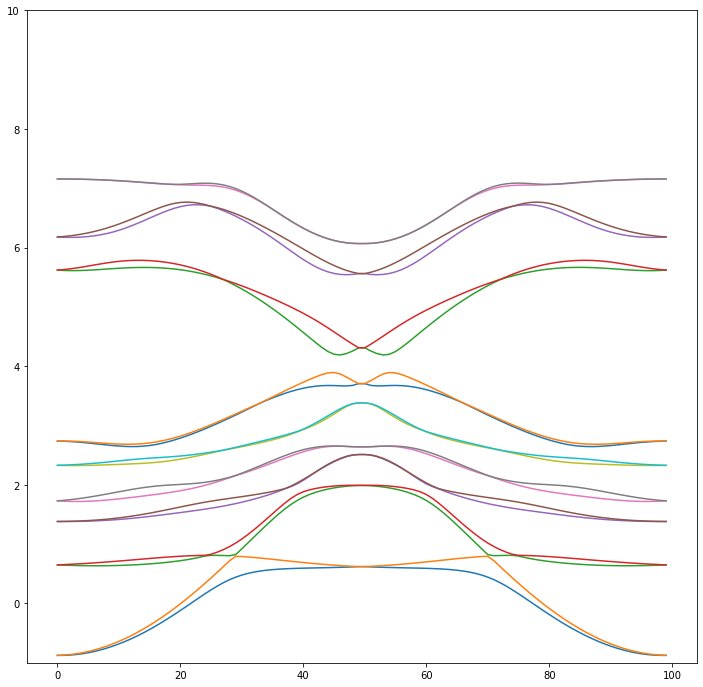

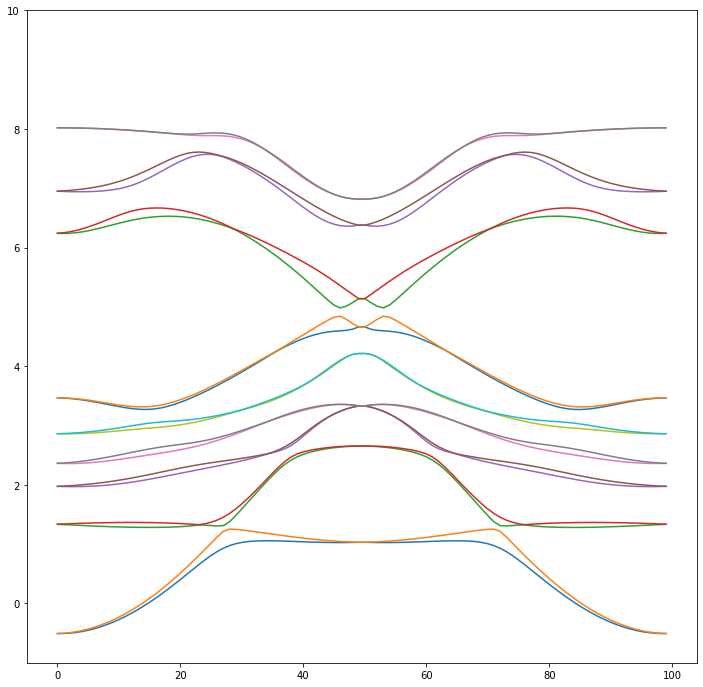

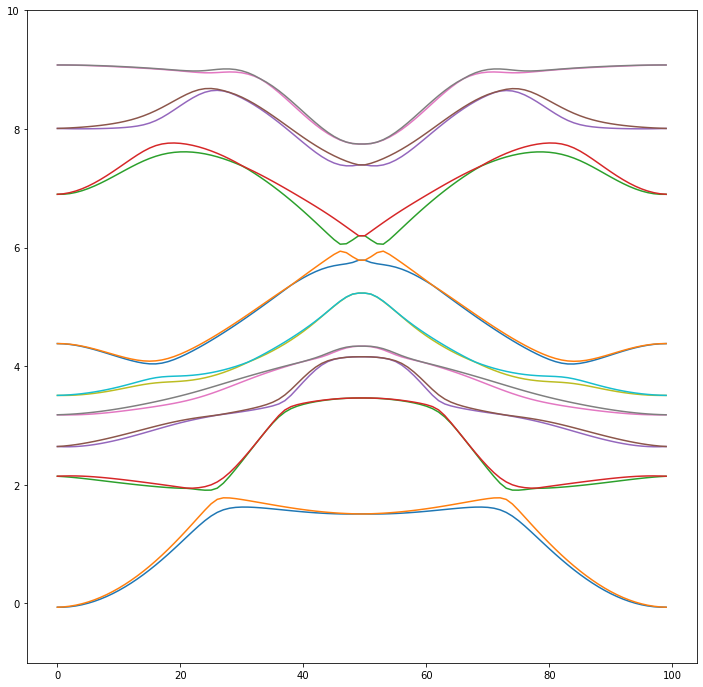

In [94]:
# Number of interpolated positions
samples = 50
interpolation_samples = 10
# High symmetry points
H = np.array([0, np.pi, np.pi])
A = np.array([0, 0, np.pi])
L = np.array([np.pi, 0, np.pi])

# Interpolate between these symmetry points
HA = [(1-i)*H+i*A for i in np.linspace(0, 1, samples)]
AL = [(1-i)*A+i*L for i in np.linspace(0, 1, samples)]
HAL = np.array(HA+AL)
HAL = np.stack([HAL.copy() for i in range(3)])

# Calculate eigenvalues
hoppings = [trivial_hoppings*(1-i)+topological_hoppings*i for i in [0, 0.45, 1,]] #np.linspace(0, 1, interpolation_samples)]
hoppings = np.stack(hoppings)
a = datetime.now()
eigvals, eigvecs = determine_band_structures(hoppings, trivial_R, torch.tensor(HAL, dtype=torch.float32))
# Plot
if True:
    plt.figure(figsize=(12, 12))
    plt.plot(eigvals[0, ::].numpy())
    plt.ylim(-1, 10)
    plt.show()
    plt.figure(figsize=(12, 12))
    plt.plot(eigvals[1, ::].numpy())
    plt.ylim(-1, 10)
    plt.show()
    plt.figure(figsize=(12, 12))
    plt.plot(eigvals[2, ::].numpy())
    plt.ylim(-1, 10)
    plt.show()


### Perform Gradient Descent on the K-values

In effect it is scattering many k-points over the full brillouin-zone, then slightly nudging their value in the direction which minimises the 12&13 bandgap energy the most, and repeating until they converge on the closest approach of the bands.

The main function is below for computing the k-space minima. It is parrallised in k-space samples and in hoppings giving, allowing it to perform ~8000 gradient descent updates per second.

In [7]:
def FindMinima(hoppings, kspace_generating_function, R_vectors, kspace_samples=100, epochs=35, learning_rate=0.1, output=True):
    """
    This function determines the k-space position where the bandgap of energy bands 12&13 are minimised.
    
    :param hoppings: This is a array of complex-values hoppings, the first index is the number of different hamiltonians to be
    tested. The shape should be [alpha, Rx, Ry, Rz, Pi, Pj]
    
    :param kspace_generator: This is a function which generates an initial distribution of kspace points of the shape
    [alpha, n, 3]
    
    :param R_vectors: These are also produced as output of the "load hoppings" method (These needn't be stacked like the hoppings).
    
    :param k_space_samples: The number of initial samples to use in the gradient descent batch.
    
    :param epochs: This is how many gradient descent cycles will be performed (defaults to 35)
    
    :param learning_rate: The proportion by which the k-space points are updated by with each gradient descent run.
    """
    
    # Generate the inital k-space positions
    kspace_points = kspace_generating_function(hoppings.shape[0], kspace_samples)

    # Using ADAM optimiser method for gradient descent
    optimiser = torch.optim.Adam([kspace_points,] , lr=learning_rate)
    
    # Stores the results of the gradient descent
    dataset = []
    
    # Repeat of n epochs for k_values*n_hoppings to converge on the minimum band energy
    for epoch in range(epochs):
        # Begins timer per epoch
        start = datetime.now()
        
        # Resets gradients
        optimiser.zero_grad()
        # Find the energy band values then the bandgap between bands 13&12 for each kpoint
        energy_bands, eigenvectors = determine_band_structures(hoppings, R_vectors, kspace_points)
        bandgap_energies = torch.abs(energy_bands[:, :, 12] - energy_bands[:, :, 11])
        # Produce a cost metric to minimise. (It is purposefully sum not average, as mean would reduce step size in this case)
        # Further it is squared so that step size reduces near minimum, as the bandgaps are roughly linear for dirac-points
        # It would otherwise result in constant step size
        cost = torch.sum(torch.square(bandgap_energies))
        # Perform gradient descent
        cost.backward()
        optimiser.step()
        
        # Find the current minima for each interpolation value.
        minimum_index = torch.argmin(bandgap_energies, axis=1)
        minimum_bandgaps = torch.take_along_dim(bandgap_energies, minimum_index[:, None], 1)[:, 0].clone().detach().numpy()
        minimum_kpoints = torch.take_along_dim(kspace_points, minimum_index[:, None, None], 1)[:, 0, :].clone().detach().numpy()
        minimum_eigenvectors = torch.take_along_dim(eigenvectors, minimum_index[:, None, None, None], 1)[:, 0, :, :].clone().detach().numpy()
        dataset.append([minimum_bandgaps, minimum_kpoints, minimum_eigenvectors])
        # Calculate some useful metrics
        time_per_epoch = datetime.now()-start
        
        if output:
            # Output results
            print(f"\n\n--------------------------------\nEpoch: {epoch}\tTime: {time_per_epoch}\n--------------------------------")
            print(f"Minimisation Metric: {cost:3.2E}")
            for i in range(hoppings.shape[0]):
                print(f"Hoppings {i} Minimum Bandgap: ({minimum_bandgaps[i]:3.2E}) eV @ K={minimum_kpoints[i, :]}")
        else:
            print(f"Epoch: {epoch}\tTime: {time_per_epoch}")
    # Produce logged plots to show the training process.
    bandgaps_per_epoch = np.array([data[0] for data in dataset])
    plt.figure(figsize=(12, 12))
    plt.plot(np.log(bandgaps_per_epoch))
    plt.ylabel("Logged Minimum Bandgap Reached")
    plt.xlabel("Epochs")
    plt.title("The minimum bandgaps found per Hamiltonian at each epoch")
    plt.show()
    
    # Finally extract the absolute minimas across all the epochs, to return as the overall minima.
    minimum_index = np.argmin(np.array([entry[0] for entry in dataset]), axis=0)
    minimum_bandgaps = np.take_along_axis(np.array([entry[0] for entry in dataset]), minimum_index[None, :], axis=0)[0, ::]
    minimum_kpoints = np.take_along_axis(np.array([entry[1] for entry in dataset]), minimum_index[None, :, None], axis=0)[0, ::]
    minimum_eigenvectors = np.take_along_axis(np.array([entry[2] for entry in dataset]), minimum_index[None, :, None, None], axis=0)[0, ::]

    return [minimum_bandgaps, minimum_kpoints, minimum_eigenvectors]

Then need to create a distribution of k-values. Edit the below function as needed to create random values. Currently set such that random values are drawn uniformly from:

$$\frac{-\pi}{2}\leq k_{x,y,z} \leq \frac{\pi}{2}$$

In [8]:
def generate_random_k_values(interpolation_values, samples):
#     k_values = np.random.rand(interpolation_values, samples, 3)
#     k_values -= 0.5
#     k_values *= np.pi

    k_values = np.zeros((interpolation_values, samples, 3))+np.array([-0.10081764,  0.22030938, np.pi])[None, None, :]
#     k_values *= 0.0
#     k_values += np.array([0.14, -0.28, np.pi])
#     (0.14024934 -0.28267923 3.1392732) is a minimum for trivial hoppings

    #k_values = np.random.rand(interpolation_values, samples, 3)
    return torch.tensor(k_values, dtype=torch.float32, requires_grad=True)

In [9]:
# Training Hyperparameters              # Values which seemed to work well.
kspace_samples = 10                      # 1000
interpolation_samples = 200
epochs = 250                            # 35
learning_rate = 0.1                     # 0.1

# Whether to output progress text at every step
text_output_per_epoch = False

Epoch: 0	Time: 0:00:01.711505
Epoch: 1	Time: 0:00:01.684691
Epoch: 2	Time: 0:00:01.691947
Epoch: 3	Time: 0:00:01.545045
Epoch: 4	Time: 0:00:01.832754
Epoch: 5	Time: 0:00:01.538452
Epoch: 6	Time: 0:00:01.660961
Epoch: 7	Time: 0:00:01.470110
Epoch: 8	Time: 0:00:01.586772
Epoch: 9	Time: 0:00:01.605286
Epoch: 10	Time: 0:00:01.646635
Epoch: 11	Time: 0:00:01.540689
Epoch: 12	Time: 0:00:01.549523
Epoch: 13	Time: 0:00:01.766360
Epoch: 14	Time: 0:00:01.692093
Epoch: 15	Time: 0:00:01.649879
Epoch: 16	Time: 0:00:01.658561
Epoch: 17	Time: 0:00:01.657809
Epoch: 18	Time: 0:00:01.634725
Epoch: 19	Time: 0:00:01.648551
Epoch: 20	Time: 0:00:01.634214
Epoch: 21	Time: 0:00:01.729548
Epoch: 22	Time: 0:00:01.621654
Epoch: 23	Time: 0:00:01.725164
Epoch: 24	Time: 0:00:01.856344
Epoch: 25	Time: 0:00:02.038531
Epoch: 26	Time: 0:00:01.924773
Epoch: 27	Time: 0:00:01.775466
Epoch: 28	Time: 0:00:01.767293
Epoch: 29	Time: 0:00:01.797476
Epoch: 30	Time: 0:00:01.783592
Epoch: 31	Time: 0:00:01.817310
Epoch: 32	Time: 0:

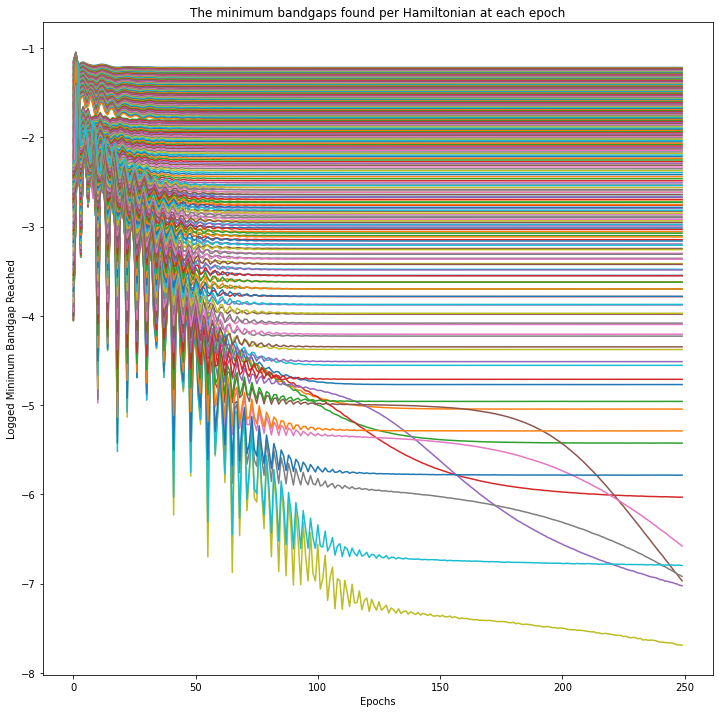

In [10]:
# Find the hoppings for a range of interpolation values:
# First interpolate samples
alphas = np.linspace(0, 1, interpolation_samples)
hoppings = np.array([trivial_hoppings*(1-i)+topological_hoppings*i for i in alphas])

# Compute
min_bandgaps, min_kpoints, min_eigenvectors = FindMinima(
    hoppings,
    generate_random_k_values,
    trivial_R,
    kspace_samples=kspace_samples,
    epochs=epochs,
    learning_rate=learning_rate,
    output=text_output_per_epoch
)

Then the band energies at various interpolation values can be plotted to show the phase transition between trivial, topological and semimetal:

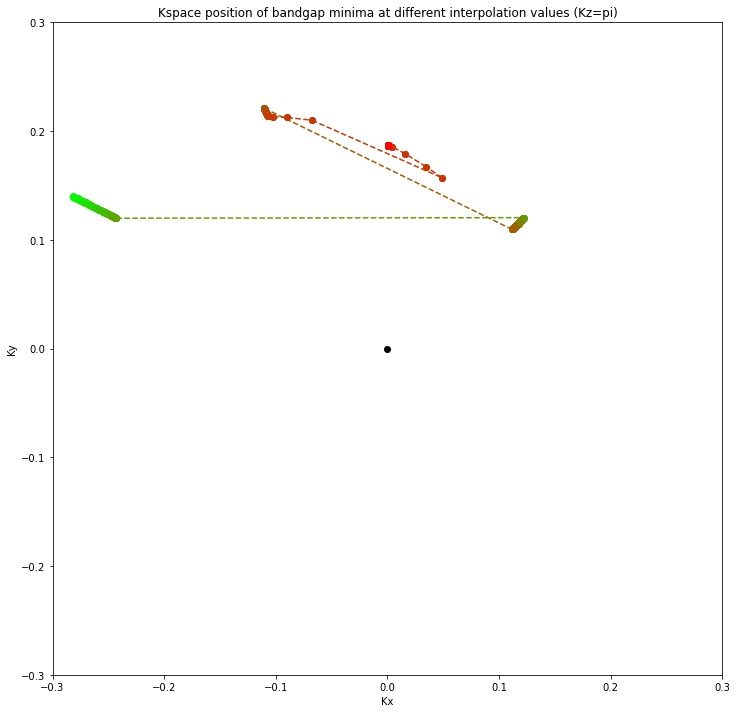

In [79]:
plt.figure(figsize=(12, 12))
plt.scatter(0, 0, c="black")
for i, alpha in enumerate(alphas):
    #print(f"{i}\t{alpha:3.2f} \t K=[{min_kpoints[i, 0]:4.3f}, {min_kpoints[i, 1]:4.3f}, {min_kpoints[i, 2]:4.3f}]")
    if i>=1:
        plt.plot([min_kpoints[i-1, 0], min_kpoints[i, 0]], [min_kpoints[i-1, 1], min_kpoints[i, 1]], "o--", color=[alpha, 1-alpha, 0])
plt.ylim(-0.3, 0.3)
plt.xlim(-0.3, 0.3)
plt.xlabel("Kx")
plt.ylabel("Ky")
plt.title("Kspace position of bandgap minima at different interpolation values (Kz=pi)")
plt.show()

In [87]:
resolution = 30
krange = 0.6
k = []
for kx in np.linspace(-krange, krange, resolution):
    for ky in np.linspace(-krange, krange, resolution):                                                                                   
        k.append(np.array([kx, ky, np.pi]))
k = torch.tensor(np.stack([np.array(k) for i in alphas], axis=0), dtype=torch.float32)
eigenvalues, _ = determine_band_structures(hoppings, trivial_R, k)
bandgaps = eigenvalues[:, :, 12]#-eigenvalues[:, :, 11]

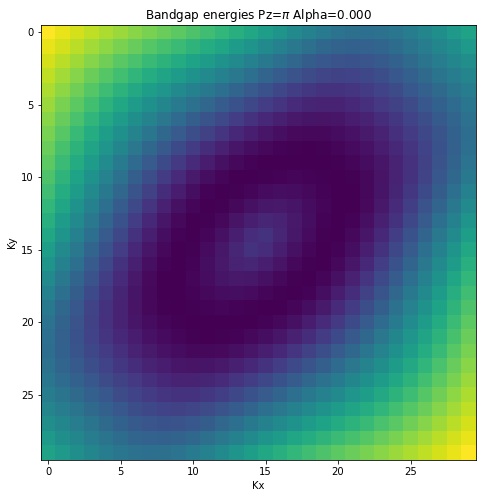

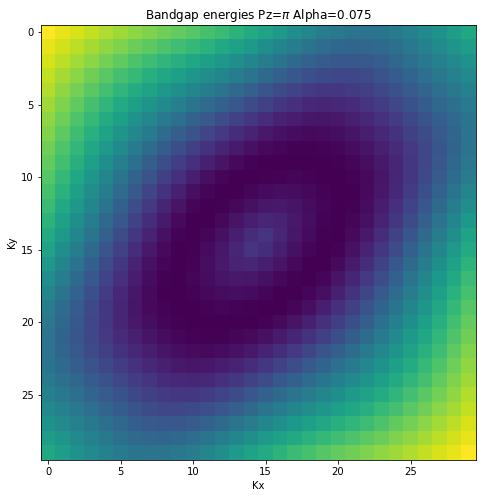

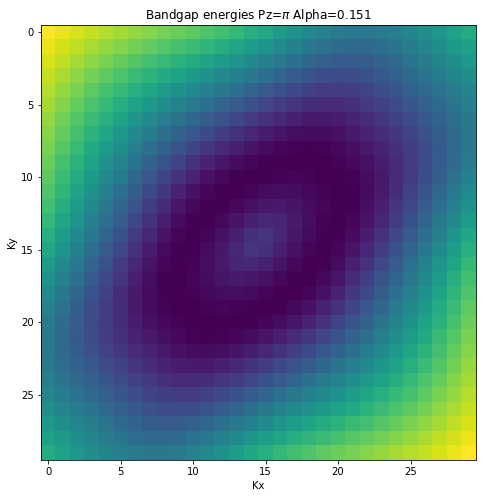

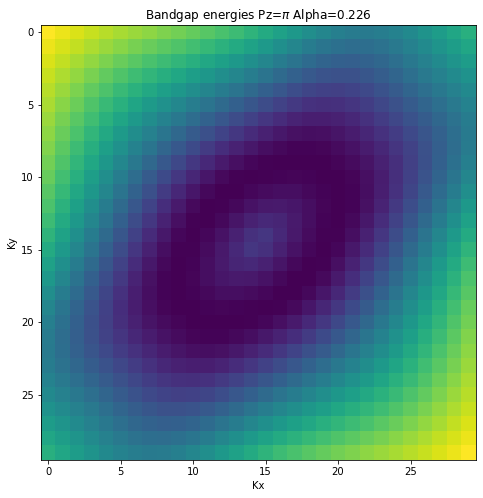

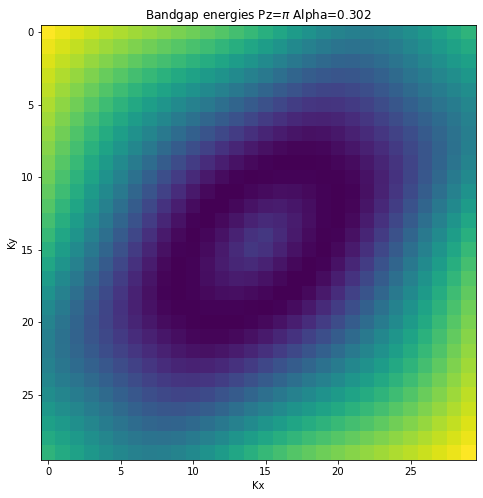

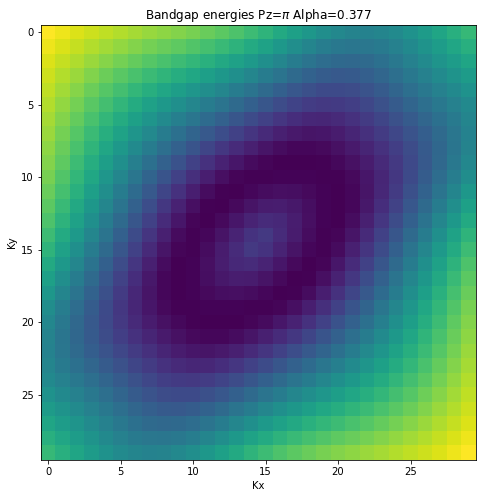

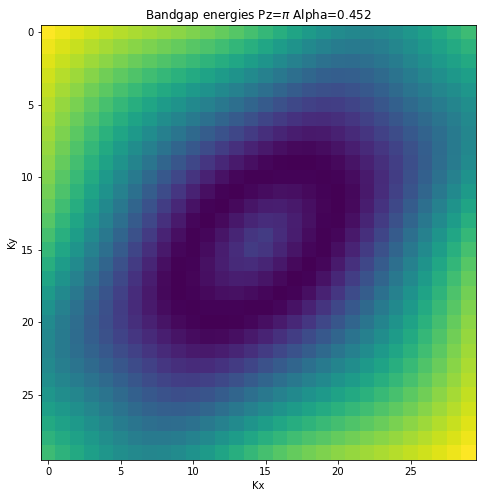

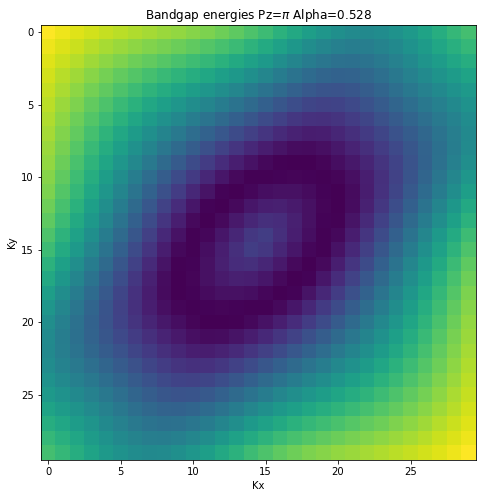

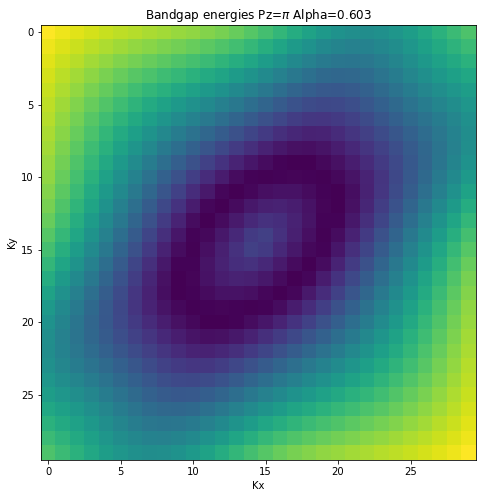

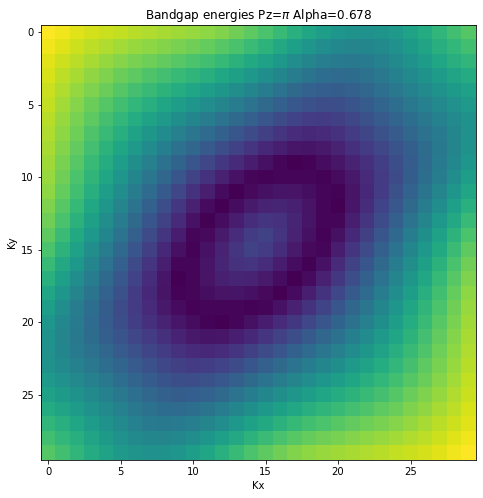

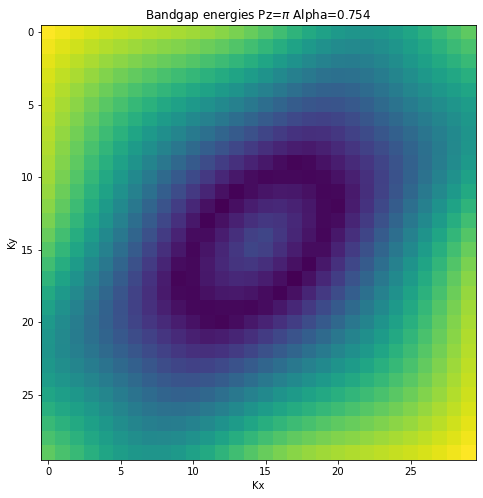

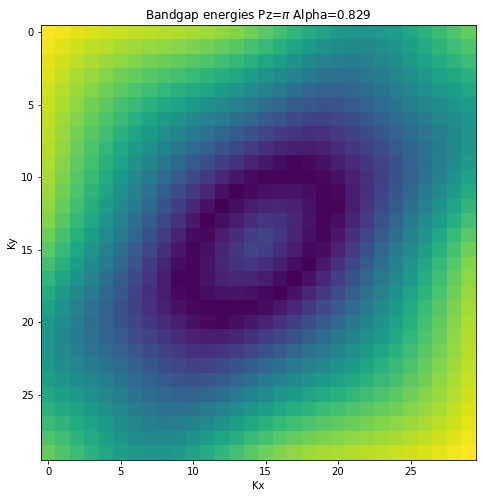

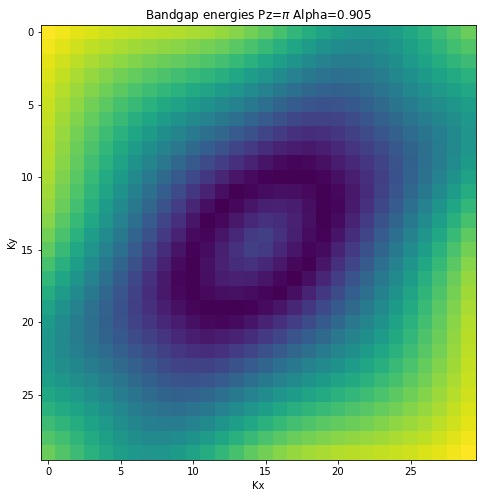

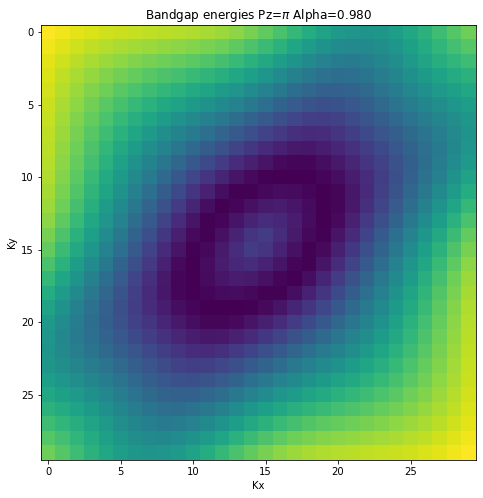

In [89]:
for i, alpha in enumerate(alphas):
    if i %15==0:
        kx = k[i, :, 0]
        ky = k[i, :, 1]
        values = bandgaps[i, :]
        plt.figure(figsize=(8, 8))
        plt.title(f"Bandgap energies Pz=$\pi$ Alpha={alpha:4.3f}")
        plt.xlabel("Kx")
        plt.ylabel("Ky")
        #plt.xlim(-krange, krange)
        #plt.ylim(-krange, krange)
        plt.imshow(values.numpy().reshape(resolution, resolution))#, vmin=0, vmax=1)
        plt.show()

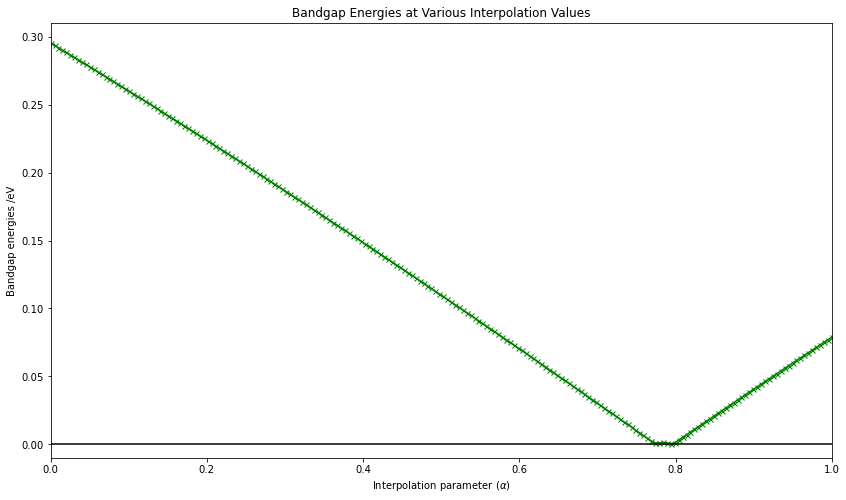

In [12]:
# Plot the bandgap energies as a function of the interpolation parameter
%matplotlib inline
plt.figure(figsize=(14, 8))
plt.plot(alphas, min_bandgaps, "x-", ms=5., c="green")
plt.axhline(0, c="black")
plt.ylim(-0.01)
plt.xlim(0, 1)
plt.title("Bandgap Energies at Various Interpolation Values")
plt.ylabel("Bandgap energies /eV")
plt.xlabel(r"Interpolation parameter ($\alpha$)")
plt.show()

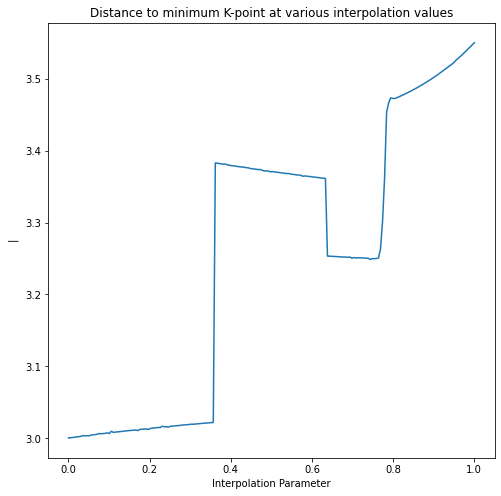

In [13]:
%matplotlib inline
fig = plt.figure(figsize = (8, 8))
plt.plot(alphas, np.sum(np.array([min_kpoints[:, i] for i in range(3)]),axis=0))
plt.title("Distance to minimum K-point at various interpolation values")
plt.ylabel("$|\vec{k}|$")
plt.xlabel("Interpolation Parameter")
plt.show()

<IPython.core.display.Javascript object>


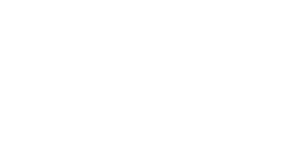

In [14]:
%matplotlib notebook
fig = plt.figure(figsize = (12, 12))
ax = plt.axes(projection ="3d")
for i, alpha in enumerate(alphas):
    if alpha<0.775:
        colour = np.array([1, 0, 0])*(1-alpha/0.775) + np.array([1, 0, 1])*alpha/0.775
    elif alpha>0.805:
        colour = "blue"
    else:
        colour="green"
    #colour = np.array([1, 0, 0])*alpha+np.array([0, 1, 0])*(1-alpha)
    ax.scatter3D(min_kpoints[i, 0], min_kpoints[i, 1], min_kpoints[i, 2], color = colour, s=15)
ax.set_xlabel("Kx")
ax.set_ylabel("Ky")
ax.set_zlabel("Kz")
ax.set_xlim(-0.3, 0.3)
ax.set_ylim(-0.3, 0.3)
ax.set_zlim(-4, 4)
ax.set_title("Minimum K-space positions")
plt.show()

Now shown is a basic plot of the bandgap energies and corresponding eigenvectors for band 12 & 13

In [15]:
basis_set = [
    "Te-px-up", "Te-py-up", "Te-pz-up", "Bi-px-up", "Bi-py-up", "Bi-pz-up",
    "I-px-up", "I-py-up", "I-pz-up", "Te-px-down", "Te-py-down", "Te-pz-down",
    "Bi-px-down", "Bi-py-down", "Bi-pz-down", "I-px-down", "I-py-down", "I-pz-down"
]

Now plotting the values for the eigenvectors at the minimum bandgaps which were found. They will be plotted for band 12 & 13:

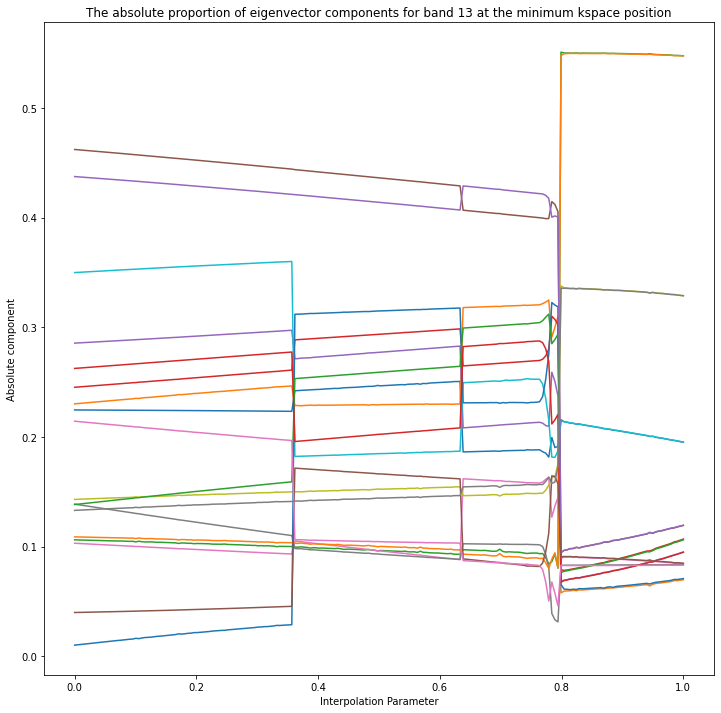

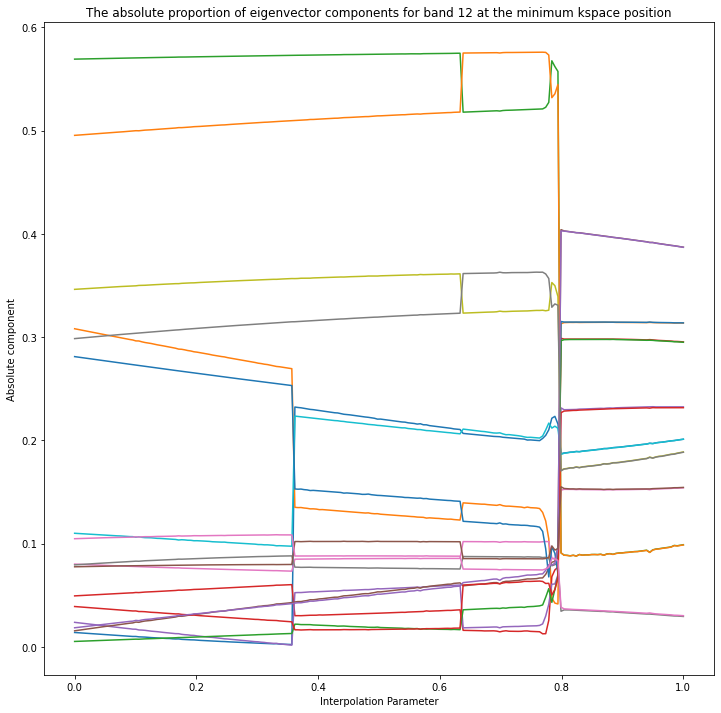

In [16]:
%matplotlib inline

plt.figure(figsize=(12, 12))
vector = np.abs(min_eigenvectors[:, :, 12])
magnitude = np.sqrt(np.sum(np.square(vector), axis=1, keepdims=True))
plt.plot(alphas, vector/magnitude)
plt.xlabel("Interpolation Parameter")
plt.ylabel("Absolute component")
plt.title("The absolute proportion of eigenvector components for band 13 at the minimum kspace position")
plt.show()

plt.figure(figsize=(12, 12))
vector = np.abs(min_eigenvectors[:, :, 11])
magnitude = np.sqrt(np.sum(np.square(vector), axis=1, keepdims=True))
plt.plot(alphas, vector/magnitude)
plt.xlabel("Interpolation Parameter")
plt.ylabel("Absolute component")
plt.title("The absolute proportion of eigenvector components for band 12 at the minimum kspace position")
plt.show()

Now for every set of components e.g. Te-Py-up & Te-Py-down the $\left\langle\hat{S_x}\right\rangle$, $\left\langle\hat{S_y}\right\rangle$ and $\left\langle\hat{S_z}\right\rangle$ will be found. This is first performed on band 12 (the valence band), then on (13 the conduction band).

For this $\frac{\hbar}{2}=1$ and $\left\langle\hat{S_x}\right\rangle$ is computed using the pauli matrices by:

$\left\langle\hat{S_x}\right\rangle=\left\langle
\phi_{\text{Te-Py}}\left(\alpha\right)|\sigma_{x}|\phi_{\text{Te-Py}}\left(\alpha\right)\right\rangle=\left\langle\bigl(\begin{smallmatrix}
\text{Te-Py-up}
\\ 
\text{Te-Py-down}
\end{smallmatrix}\bigr)\left | \bigl(\begin{smallmatrix}
1 & 0\\ 
0 & -1
\end{smallmatrix}\bigr) \right |\bigl(\begin{smallmatrix}
\text{Te-Py-up}
\\ 
\text{Te-Py-down}
\end{smallmatrix}\bigr)\right\rangle$

In [17]:
pauli_matrices = {"Sx": np.array([[0, 1+0j], [1, 0]]), "Sy": np.array([[0, -1j], [1j, 0]]), "Sz": np.array([[1+0j, 0], [0, -1]])}
_ = [print(f"{key}\n{val}\n") for key, val in pauli_matrices.items()]

Sx
[[0.+0.j 1.+0.j]
 [1.+0.j 0.+0.j]]

Sy
[[ 0.+0.j -0.-1.j]
 [ 0.+1.j  0.+0.j]]

Sz
[[ 1.+0.j  0.+0.j]
 [ 0.+0.j -1.+0.j]]



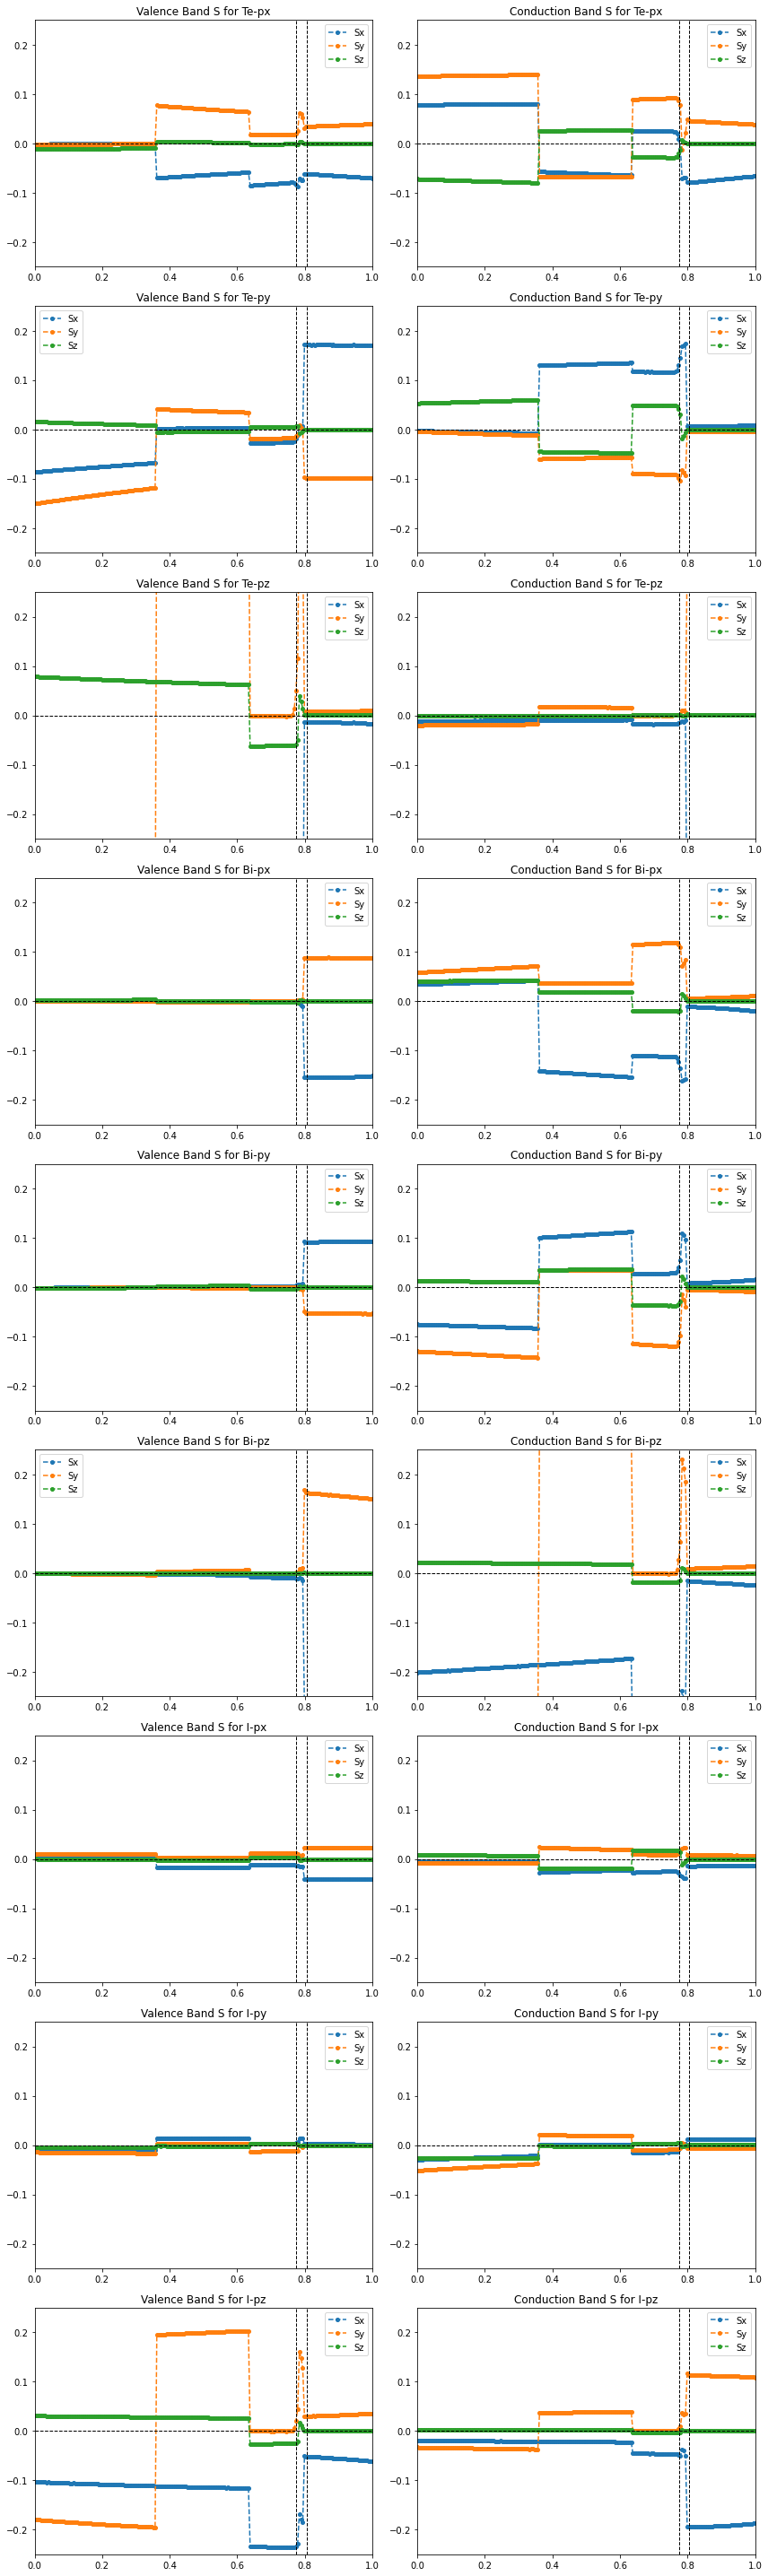

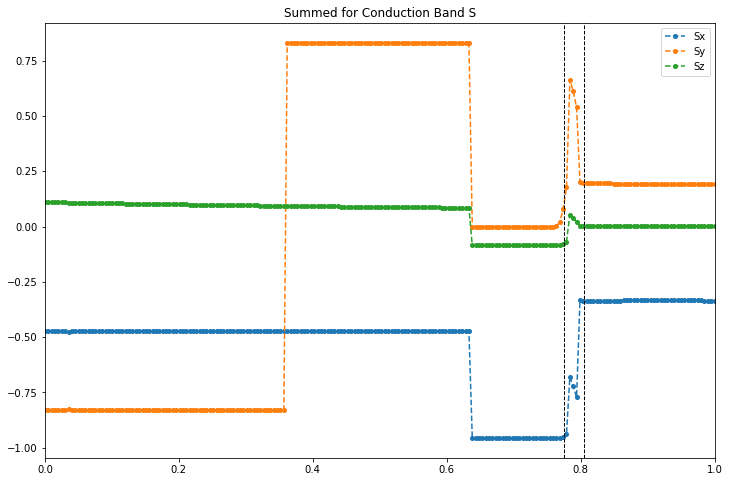

In [86]:
%matplotlib inline
# Go through basis-combinations:
dagger = lambda x: np.conj(x).T

fig, ax = plt.subplots(9, 2, figsize=(12, 40))
# Valance band
valence_eigenvectors = min_eigenvectors[:, :, 11]
S_total = {"Sx": np.zeros(200), "Sy": np.zeros(200), "Sz": np.zeros(200)}
for i in range(9):
    # Calculate the components of S
    # Extract the up and down components then create a 2-component state from them
    up = valence_eigenvectors[:, i]
    down = valence_eigenvectors[:, i+9]
    state = np.array([up, down])
    #state = state/np.sqrt(np.square(np.abs(state)).sum(axis=0, keepdims=True))
    # Find the expectation values of the pauli matrix operators
    S_components = {key: np.einsum("ac, cb, ba -> a", dagger(state), val, state).real for key, val in pauli_matrices.items()}
    S_total["Sx"] += S_components["Sx"]
    S_total["Sy"] += S_components["Sy"]
    S_total["Sz"] += S_components["Sz"]
    ax[i, 0].set_title(f"Valence Band S for {basis_set[i][:-3]}")
    ax[i, 0].set_ylim(-0.25, .25)
    ax[i, 0].set_xlim(0, 1)
    ax[i, 0].plot(alphas, S_components["Sx"], "o--", label="Sx", ms=4)
    ax[i, 0].plot(alphas, S_components["Sy"], "o--", label="Sy", ms=4)
    ax[i, 0].plot(alphas, S_components["Sz"], "o--", label="Sz", ms=4)
    ax[i, 0].axhline(0, linestyle="--", c="black", lw=1)
    ax[i, 0].axvline(0.775, linestyle="--", c="black", lw=1)
    ax[i, 0].axvline(0.805, linestyle="--", c="black", lw=1)
    ax[i, 0].legend()
# Conduction band
valence_eigenvectors = min_eigenvectors[:, :, 12]
for i in range(9):
    # Calculate the components of S
    # Extract the up and down components then create a 2-component state from them
    up = valence_eigenvectors[:, i]
    down = valence_eigenvectors[:, i+9]
    state = np.array([up, down])
    #state = state/np.sqrt(np.square(np.abs(state)).sum(axis=0, keepdims=True))
    # Find the expectation values of the pauli matrix operators
    S_components = {key: np.einsum("ac, cb, ba -> a", dagger(state), val, state).real for key, val in pauli_matrices.items()}
    ax[i, 1].set_title(f"Conduction Band S for {basis_set[i][:-3]}")
    ax[i, 1].set_ylim(-.25, .25)
    ax[i, 1].set_xlim(0, 1)
    ax[i, 1].plot(alphas, S_components["Sx"], "o--", label="Sx", ms=4)
    ax[i, 1].plot(alphas, S_components["Sy"], "o--", label="Sy", ms=4)
    ax[i, 1].plot(alphas, S_components["Sz"], "o--", label="Sz", ms=4)
    ax[i, 1].axhline(0, linestyle="--", c="black", lw=1)
    ax[i, 1].axvline(0.775, linestyle="--", c="black", lw=1)
    ax[i, 1].axvline(0.805, linestyle="--", c="black", lw=1)
    ax[i, 1].legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))
plt.title(f"Summed for Conduction Band S")
plt.xlim(0, 1)
plt.plot(alphas, S_total["Sx"], "o--", label="Sx", ms=4)
plt.plot(alphas, S_total["Sy"], "o--", label="Sy", ms=4)
plt.plot(alphas, S_total["Sz"], "o--", label="Sz", ms=4)
plt.axvline(0.775, linestyle="--", c="black", lw=1)
plt.axvline(0.805, linestyle="--", c="black", lw=1)
plt.legend()
plt.show()

In [19]:

A = np.array([[3.7532455, -2.1669373, 0.0000000], [0.0000000, 4.3338746, 0.0000000], [0.0000000, 0.0000000, 6.8708538]])
B = np.array([[1.6740673, 0.0000000, 0.0000000], [0.8370336, 1.4497848, 0.0000000], [0.0000000, 0.0000000, 0.9144694]])

print(np.matmul(A, B.T))
print(B)
print(np.linalg.inv(A)*np.pi*2)

[[ 6.28318556e+00 -1.67544240e-07  0.00000000e+00]
 [ 0.00000000e+00  6.28318552e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  6.28318555e+00]]
[[1.6740673 0.        0.       ]
 [0.8370336 1.4497848 0.       ]
 [0.        0.        0.9144694]]
[[1.67406723 0.83703362 0.        ]
 [0.         1.44978475 0.        ]
 [0.         0.         0.91446936]]
